In [1]:
import os
import sys
from time import time
from collections import defaultdict, Counter
from heapq import heappush, heappop, heapify

import numpy as np
import scipy.stats as sps
from nltk.tokenize import RegexpTokenizer
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

Читаем документы и считаем simhash-и.

In [34]:
tokenize = RegexpTokenizer("\w+").tokenize
positive_hash = lambda word: hash(word) % ((sys.maxsize + 1) * 2)
dir_path = "/home/ilivans/data/simple.wiki/pages"
assert os.path.exists(dir_path)

In [43]:
def remained_time(start, i, total, step=500):
    if i % step == 0:
        spent = time() - start
        clear_output()
        print "Processed: {}\tRemained time: {:.2f} hours".format(
            i + 1, (float(total) / (i + 1) - 1) * spent / 60 / 60)

In [37]:
%%time
Xs = []
simhashes = []
simhash_to_name = defaultdict(lambda : [])
start = time()
for i, filename in enumerate(os.listdir(_DIR_PATH)):
    filepath = os.path.join(_DIR_PATH, filename)
    with open(filepath) as f:
        doc = f.read()

    X = np.zeros(64, dtype=np.int32)
    tokens = tokenize(doc)
    for hash_ in map(positive_hash, tokens):
        X += np.array(list(format(hash_, "064b")), dtype=np.int32)
    X *= 2
    X -= len(tokens)    
    Xs.append(X)

    simhash = np.uint64(int("".join(map(str, np.clip(np.sign(X), 0, 1))), 2))
    simhashes.append(simhash)
    simhash_to_name[simhash].append(filename)
    
    remained_time(start, i, 135000)

clear_output()

CPU times: user 5h 8min 55s, sys: 28.8 s, total: 5h 9min 24s
Wall time: 5h 8min 14s


In [38]:
Xs = np.array(Xs)
simhashes = np.array(simhashes)
np.save("Xs", Xs)
np.save("simhashes", simhashes)

In [2]:
Xs = np.load("Xs.npy")
simhashes = np.load("simhashes.npy")

In [3]:
SIMHASH_SIZE = 64
MAX_DISTANCE = 3
num_samples = len(simhashes)
print "Number of samples:", num_samples
print "SimHash example:", format(simhashes[0], "b")
print "SimHash size:", SIMHASH_SIZE

Number of samples: 135325
SimHash example: 101001000000000111010100000101110001000100111110000
SimHash size: 64


## Точный поиск полудублей.

Поделим simhash-и на 4 части для индексирования.

In [31]:
NUM_PARTS = MAX_DISTANCE + 1
PART_SIZE = SIMHASH_SIZE / NUM_PARTS

In [32]:
neg_part_mask = "0" * PART_SIZE
pos_part_mask = "1" * PART_SIZE
masks = [neg_part_mask * part_id + pos_part_mask + neg_part_mask * (NUM_PARTS - part_id - 1)\
         for part_id in range(NUM_PARTS)]
masks = np.array([int(mask, 2) for mask in masks], dtype=np.uint64)

def get_part(simhash, part_id):
    return int(simhash & masks[part_id]) >> (PART_SIZE * (NUM_PARTS - part_id - 1))

In [33]:
simhashes_parts = np.zeros((len(simhashes), NUM_PARTS), dtype=np.int32)
for simhash_id, simhash in enumerate(simhashes):
    for part_id in xrange(NUM_PARTS):
        simhashes_parts[simhash_id][part_id] = get_part(simhash, part_id)

Построим индексы.

In [34]:
indices = [[list() for __ in xrange(2 ** PART_SIZE)] for _ in xrange(NUM_PARTS)]
for simhash_id in xrange(num_samples):
    simhash_parts = simhashes_parts[simhash_id]
    for part_id in xrange(NUM_PARTS):
        indices[part_id][simhash_parts[part_id]].append(simhash_id)

Заведём сет удовлетворяющих xor-ов между хешами.

In [35]:
# This function will serve us later as well
def permutations(num_ones, size=SIMHASH_SIZE, start=0):
    # Returns all possible positions of `num_ones` ones in a sequence of `size` bits,
    # whereas the other bits are considered as zeros
    if num_ones == 0:
        yield []
        return
    for position in range(start, size):
        for positions in permutations(num_ones - 1, size, position + 1):
            yield [position] + positions

In [36]:
accepted_xors = set()

for num_ones in xrange(MAX_DISTANCE + 1):
    for positions in permutations(num_ones):
        xor = ["0"] * SIMHASH_SIZE
        for pos in positions:
            xor[pos] = "1"
        accepted_xors.add(np.uint64(int("".join(xor), 2)))

print len(accepted_xors)

43745


In [37]:
def similar(hash1, hash2):
    return (hash1 ^ hash2) in accepted_xors

Прокластеризуем хеши независимо.

In [45]:
%%time

groups_sizes = []
start = time()
for simhash_id, simhash in enumerate(simhashes):
    group = set()
    simhash_parts = simhashes_parts[simhash_id]
    for part_id, part in enumerate(simhash_parts):
        for candidate_id in indices[part_id][part]:
            if similar(simhash, simhashes[candidate_id]):
                group.add(candidate_id)
    
    groups_sizes.append(len(group))
    
    remained_time(start, simhash_id, num_samples)

clear_output()

CPU times: user 1h 28min 9s, sys: 22.8 s, total: 1h 28min 32s
Wall time: 1h 27min 54s


In [46]:
groups_sizes = np.array(groups_sizes)
np.save("groups_sizes", groups_sizes)

In [47]:
groups_sizes = np.load("groups_sizes.npy")

## Вероятностный поиск полудублей.

Считаем побитные вероятности.

In [12]:
%%time
alpha = 0.1  # suppose that we add/remove `alpha` of the words in a document
stds = Xs.std(axis=0) * alpha
distributions = [sps.norm(0, std) for std in stds]
probabilities = []  # probabilities
for X in np.abs(Xs):
    probabilities.append([dist.cdf(-x) for x, dist in zip(X, distributions)])

probabilities = np.array(probabilities)
np.save("probabilities", probabilities)

CPU times: user 7min 2s, sys: 420 ms, total: 7min 3s
Wall time: 7min 3s


In [48]:
probabilities = np.load("probabilities.npy")

Сортируем вычисленные вероятности.

In [49]:
most_probable_flipped_bits = []
for probs in probabilities:
    most_probable_flipped_bits.append(np.flip(np.argsort(probs), 0))
most_probable_flipped_bits = np.array(most_probable_flipped_bits)

Т.к. некоторые документы имеют один и тот же симхеш, заведём счётчик документов для каждого симхэша.

In [50]:
simhashes_counts = Counter(simhashes)

Заведём вспомогательные конструкции для флипа битов.

In [ ]:
# Precompute all possible combinations of flipped bits' positions
flipped_positions = []
for num_flipped in range(1, MAX_DISTANCE + 1):
    for positions in permutations(num_flipped, SIMHASH_SIZE):
        flipped_positions.append(positions)
powers_of_two = [np.uint64(2 ** n) for n in xrange(0, SIMHASH_SIZE)]  # used for bits flipping

In [56]:
%%time

proportions_found = []  # found subduplicates proportions for each `k` averaged over all documents
start = time()

for simhash_id, (simhash, group_size, probs, bits_indices) in enumerate(zip(simhashes, groups_sizes, probabilities,
                                                                            most_probable_flipped_bits)):
    prob_total_init = np.prod(1. - probs)
    heap = []
    for positions in flipped_positions:
        flipped_bits = [bits_indices[pos] for pos in positions]
        prob_total = np.copy(prob_total_init)
        for bit in flipped_bits:
            prob_total *= probs[bit] / (1. - probs[bit])
        heappush(heap, (-prob_total, flipped_bits))
    
    found = simhashes_counts[simhash]
    nums_found_local = [found]
    for k in range(1, len(heap) + 1):
        _, flipped_bits = heappop(heap)
        simhash_flipped = simhash.copy()
        for bit in flipped_bits:
            simhash_flipped ^= powers_of_two[SIMHASH_SIZE - bit - 1]
        if simhash_flipped in simhashes_counts:
            found += simhashes_counts[simhash_flipped]
        nums_found_local.append(found)
        if found == group_size:
            nums_found_local += [found] * len(heap)
            break
    
    if simhash_id == 0:
        proportions_found = np.array(nums_found_local) / float(group_size)
    else:
        # Update proportions
        proportions_found = proportions_found * simhash_id + np.array(nums_found_local) / float(group_size)
        proportions_found /= simhash_id + 1
    
    # Just time measures
    remained_time(start, simhash_id, num_samples)

clear_output()

CPU times: user 15h 6min 22s, sys: 6min 5s, total: 15h 12min 27s
Wall time: 15h 7min 12s


In [64]:
np.save("proportions", proportions_found)

Построим график зависимости найденной доли полудубликтов от числа обращений k.

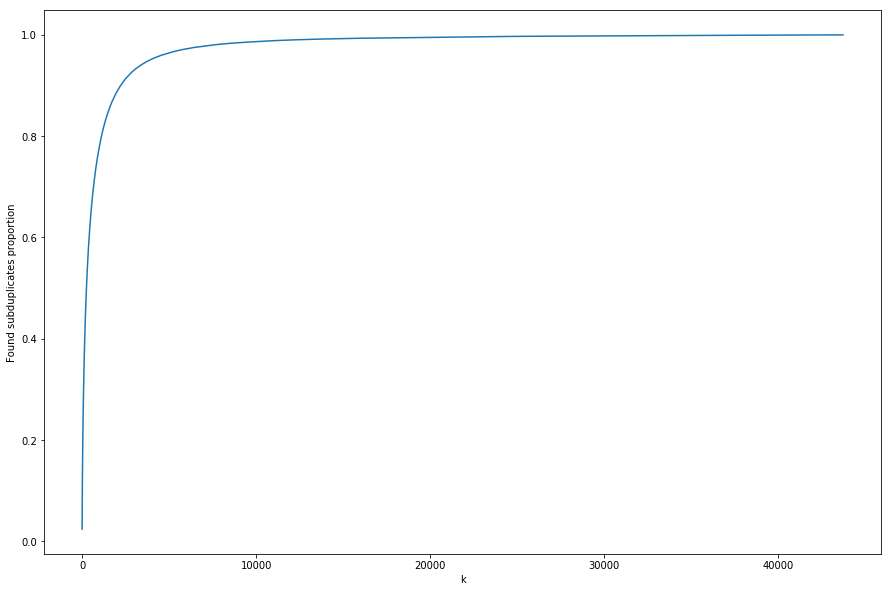

In [62]:
plt.figure(figsize=(15, 10))
plt.plot(proportions_found)
plt.xlabel("k")
plt.ylabel("Found subduplicates proportion");

Среднее число обращений к множеству симхешей для обнаружения 30%, 50% и 80% полудубликатов:

In [63]:
print [np.searchsorted(proportions_found, proportion) for proportion in (0.3, 0.5, 0.8)]

[84, 248, 1112]
